# 1. Configuración del Entorno e Instalación de Dependencias

In [1]:
# Este bloque instala todas las bibliotecas necesarias para XAI y la generación con LLM.
%%capture
import os
import sys

# 1.1 Instalación de Clingo (Solucionador ASP) para aspBEEF
!pip install clingo

# 1.2 Instalación de Bibliotecas XAI Estándar
!pip install shap lime

# 1.3 Instalación de Araucana-XAI
!pip install araucanaxai

# 1.4 Instalación de Unsloth y Dependencias LLM
try:
    import torch
except ImportError:
    !pip install torch


# Instalamos primero unsloth-zoo desde GitHub para saltar el chequeo de PyPI
!pip install --upgrade --no-cache-dir git+https://github.com/unslothai/unsloth-zoo.git

# Ahora instalamos Unsloth principal (ya encontrará la 'zoo' instalada)
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Instalamos trl, peft, etc.
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

print("Configuración del Entorno Completada.")

# 2. Carga de Datos, Preprocesamiento y Entrenamiento del Modelo Base

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Configuración ---
# Seleccionar modo de dataset: 'simple' (Iris) o 'medical' (Cáncer de Mama)
# Cambie esta variable para alternar entre los experimentos.
DATASET_MODE = 'medical'

def load_data_pipeline(mode='simple'):
    """
    Carga y prepara los datasets según el modo seleccionado.
    Retorna el dataframe, nombres de objetivos y lista de características categóricas.
    """
    if mode == 'simple':
        data = load_iris()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['target'] = data.target
        target_names = data.target_names
        cat_features = []
    elif mode == 'medical':
        # Usamos Breast Cancer Wisconsin como proxy de datos médicos
        data = load_breast_cancer()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['target'] = data.target
        target_names = data.target_names
        cat_features = []

    return df, target_names, cat_features

# Cargar Datos
df, target_names, cat_features = load_data_pipeline(DATASET_MODE)
X = df.drop('target', axis=1)
y = df['target']

# División de Datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento de un Modelo de Caja Negra (Random Forest)
# Usamos Random Forest porque es suficientemente complejo para requerir explicación,
# pero robusto y fácil de entrenar para esta demostración.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación Básica
y_pred = model.predict(X_test)
print(f"Precisión del Modelo en dataset {DATASET_MODE}: {accuracy_score(y_test, y_pred):.4f}")

# Selección de una instancia específica para explicar (ej. la primera del test)
instance_idx = 8
instance = X_test.iloc[[instance_idx]]
true_label = y_test.iloc[instance_idx]
pred_label = y_pred[instance_idx]

print(f"\nExplicando Instancia {instance_idx}:")
if DATASET_MODE == 'simple':
    print(f"Etiqueta Real: {target_names[true_label]}")
    print(f"Etiqueta Predicha: {target_names[pred_label]}")
else:
    # Ajuste para etiquetas binarias (0: Maligno, 1: Benigno)
    print(f"Etiqueta Real: {target_names[true_label]}")
    print(f"Etiqueta Predicha: {target_names[pred_label]}")

Precisión del Modelo en dataset medical: 0.9649

Explicando Instancia 8:
Etiqueta Real: benign
Etiqueta Predicha: malignant


# 3.1 Implementación del Explicador SHAP (Con Gráfico)


--- Gráfico SHAP (Clase Predicha: 0) ---


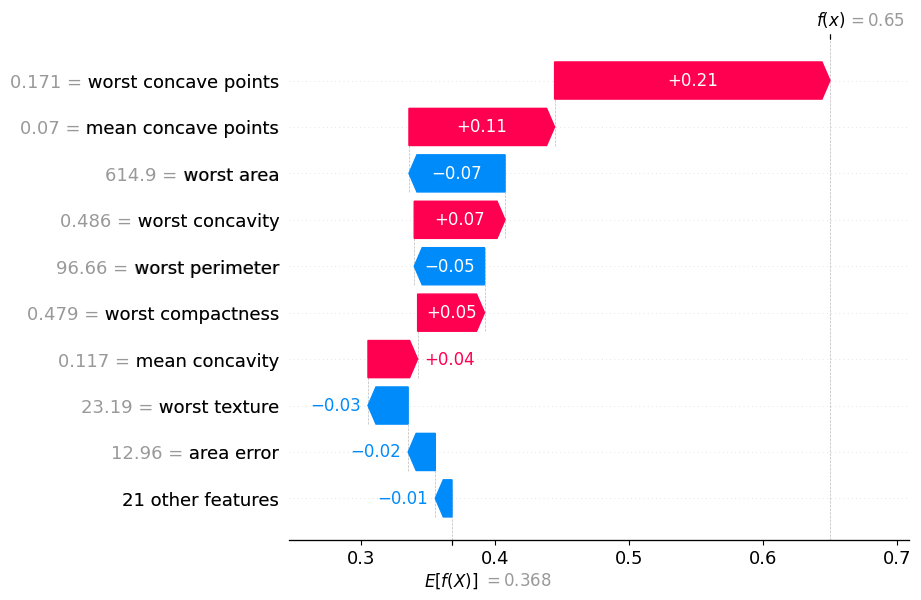


Salida JSON generada para el LLM:
{'method': 'SHAP', 'contributors': [{'feature': 'worst concave points', 'value': 0.1708, 'impact': 0.20550462622456062, 'direction': 'positivo'}, {'feature': 'mean concave points', 'value': 0.06987, 'impact': 0.10869426280099301, 'direction': 'positivo'}, {'feature': 'worst area', 'value': 614.9, 'impact': -0.07171263145399816, 'direction': 'negativo'}, {'feature': 'worst concavity', 'value': 0.4858, 'impact': 0.06778037041758138, 'direction': 'positivo'}, {'feature': 'worst perimeter', 'value': 96.66, 'impact': -0.052477453227382835, 'direction': 'negativo'}]}


In [3]:
import shap
import matplotlib.pyplot as plt

def run_shap_explainer(model, X_train, instance, show_plot=True):
    """
    Genera valores SHAP para una sola instancia.
    Muestra un gráfico waterfall y retorna una descripción estructurada.
    """
    # 1. Configuración del Explicador
    # Usar TreeExplainer para modelos de árboles (más rápido/exacto)
    explainer = shap.TreeExplainer(model)

    # Calculamos los valores en formato "raw" (arrays) para el JSON
    shap_values = explainer.shap_values(instance)

    # 2. Determinar la clase predicha
    pred_class = model.predict(instance)[0]

    # 3. Visualización Gráfica (NUEVO BLOQUE)
    if show_plot:
        print(f"\n--- Gráfico SHAP (Clase Predicha: {pred_class}) ---")
        # Para graficar, necesitamos un objeto 'Explanation' moderno, no solo arrays.
        # Volvemos a llamar al explainer pero usando la sintaxis de llamada directa
        explanation_obj = explainer(instance)

        # Ajuste de dimensiones: Random Forest devuelve (n_samples, n_features, n_classes)
        # Seleccionamos: la instancia 0, todas las features, y la clase predicha.
        if len(explanation_obj.shape) == 3:
            explanation_plot = explanation_obj[0, :, pred_class]
        else:
            explanation_plot = explanation_obj[0]

        # Generamos el gráfico de cascada (Waterfall)
        shap.plots.waterfall(explanation_plot, show=False)
        plt.show() # Forzamos que se muestre en Colab

    # 4. Procesamiento de datos para el JSON (Igual que antes)
    # Manejo de diferencias de forma en versiones de shap para los arrays
    if isinstance(shap_values, list):
        vals = shap_values[pred_class] # Random Forest suele devolver lista de arrays
        if len(vals.shape) == 2: vals = vals[0] # Si es (1, features) -> (features,)
    else:
        if len(shap_values.shape) == 2:
             vals = shap_values[0]
        else:
             vals = shap_values[0, :, pred_class]

    feature_names = X_train.columns
    # Crear pares característica-importancia
    feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['feature', 'shap_value'])
    feature_importance['abs_value'] = feature_importance['shap_value'].abs()
    feature_importance = feature_importance.sort_values(by='abs_value', ascending=False)

    # 5. Estructurar para el LLM
    top_n = 5
    shap_explanation = {
        "method": "SHAP",
        "contributors": []
    }

    for index, row in feature_importance.head(top_n).iterrows():
        shap_explanation["contributors"].append({
            "feature": row['feature'],
            "value": float(instance[row['feature']].values[0]),
            "impact": float(row['shap_value']),
            "direction": "positivo" if row['shap_value'] > 0 else "negativo"
        })

    return shap_explanation

# Ejecución
shap_output = run_shap_explainer(model, X_train, instance, show_plot=True)
print("\nSalida JSON generada para el LLM:")
print(shap_output)

# 3.2 Implementación del Explicador LIME (Con Gráfico)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



--- Gráfico LIME ---


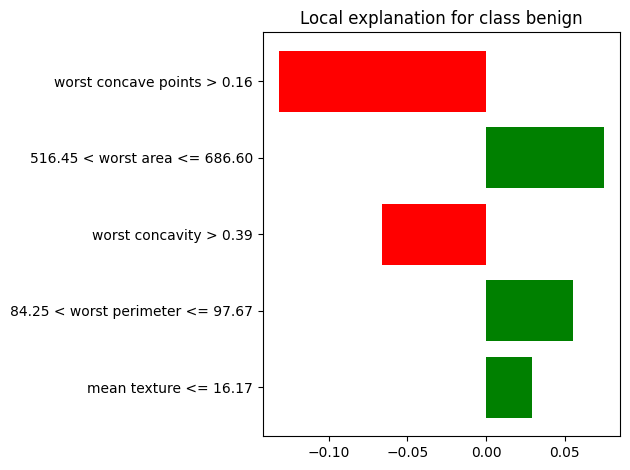


Salida JSON generada para el LLM:
{'method': 'LIME', 'rules': [{'condition': 'worst concave points > 0.16', 'weight': -0.13176016636029306, 'direction': 'contradice'}, {'condition': '516.45 < worst area <= 686.60', 'weight': 0.07480953050117248, 'direction': 'apoya'}, {'condition': 'worst concavity > 0.39', 'weight': -0.06603051587575082, 'direction': 'contradice'}, {'condition': '84.25 < worst perimeter <= 97.67', 'weight': 0.05500070039645884, 'direction': 'apoya'}, {'condition': 'mean texture <= 16.17', 'weight': 0.029506341977031718, 'direction': 'apoya'}]}


In [4]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

def run_lime_explainer(model, X_train, instance, class_names, show_plot=True):
    """
    Genera una explicación LIME para una sola instancia.
    Muestra un gráfico de barras y retorna una descripción estructurada.
    """
    training_data = np.array(X_train)

    # 1. Configuración inicial de LIME
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=training_data,
        feature_names=X_train.columns,
        class_names=class_names,
        mode='classification',
        verbose=False,
        random_state=42
    )

    # 2. Generación de la explicación
    exp = explainer.explain_instance(
        data_row=instance.values[0],
        predict_fn=model.predict_proba,
        num_features=5
    )

    # 3. Visualización Gráfica
    if show_plot:
        print(f"\n--- Gráfico LIME ---")
        # LIME tiene un método nativo para generar figuras de matplotlib
        exp.as_pyplot_figure()
        plt.tight_layout() # Ajusta los márgenes para que no se corten los textos
        plt.show()

    # 4. Estructurar para el LLM
    lime_explanation = {
        "method": "LIME",
        "rules": []
    }

    # Extraer reglas (lista de tuplas: (condición_característica, peso)
    for feature_cond, weight in exp.as_list():
        lime_explanation["rules"].append({
            "condition": feature_cond,
            "weight": weight,
            "direction": "apoya" if weight > 0 else "contradice"
        })

    return lime_explanation

# Ejecución
lime_output = run_lime_explainer(model, X_train, instance, target_names, show_plot=True)
print("\nSalida JSON generada para el LLM:")
print(lime_output)

# 3.3 Implementación del Explicador Araucana-XAI


--- Árbol Explicativo Araucana (Vecindad Uniforme) ---


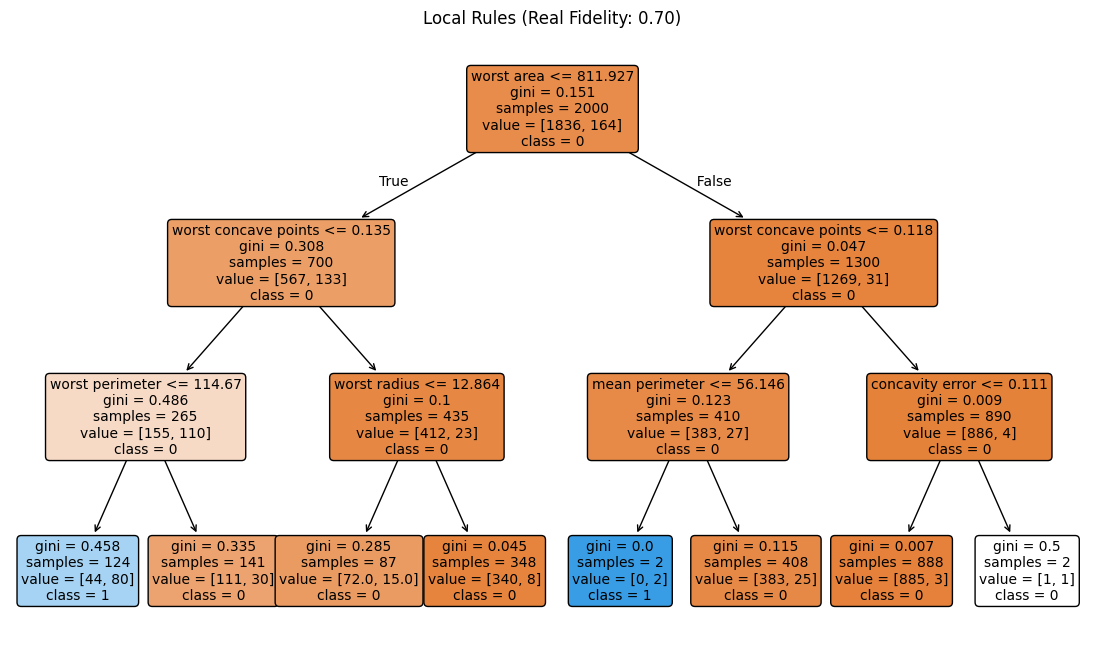


Salida JSON generada para el LLM:
Método: Araucana-XAI
Fidelidad: 0.7


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
import araucanaxai
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

def run_araucana_explainer(model, X_train, X_test, instance_idx, feature_names, show_plot=True):
    """
    Ejecuta Araucana XAI generando un árbol de decisión local.
    Incluye cálculo manual de fidelidad (Auditoría Externa) para evitar errores.
    """
    # --- GESTIÓN DE WARNINGS ---
    warnings.filterwarnings("ignore")

    # 1. Wrapper para compatibilidad Pandas/Numpy
    def predict_wrapper(X_numpy):
        if isinstance(X_numpy, pd.DataFrame):
            return model.predict(X_numpy)
        # Reconstruimos DF para mantener nombres de columnas correctos
        df_temp = pd.DataFrame(X_numpy, columns=feature_names)
        return model.predict(df_temp)

    # 2. Configuración
    cat_mask = [False] * len(feature_names)

    # 3. Preparar Instancia Objetivo
    target_instance = X_test.iloc[instance_idx].values.reshape(1, -1)
    target_pred = predict_wrapper(target_instance)

    try:
        # 4. Ejecutar Araucana
        explanation_tree = araucanaxai.run(
            x_target=target_instance,
            y_pred_target=target_pred,
            x_train=X_train.values,
            feature_names=list(feature_names),
            cat_list=cat_mask,
            neighbourhood_size=200,
            oversampling='uniform',
            oversampling_size=2000,
            max_depth=3,
            predict_fun=predict_wrapper
        )

        tree_obj = explanation_tree['tree']

        # --- CÁLCULO DE FIDELIDAD (AUDITORÍA EXTERNA) ---
        # Como Araucana con 'uniform' no devuelve 'X_neigh', generamos nuestros
        # propios vecinos para auditar la calidad del árbol.
        try:
            # A. Generamos 100 vecinos con ruido local
            # (Simulamos el vecindario local para ver si el árbol acierta)
            noise = np.random.normal(0, 0.5, (100, X_train.shape[1]))
            X_audit = target_instance + noise

            # B. Obtenemos predicciones
            y_blackbox = predict_wrapper(X_audit) # Lo que dice el Random Forest
            y_surrogate = tree_obj.predict(X_audit) # Lo que dice el Árbol Araucana

            # C. Calculamos coincidencia
            fidelity_val = accuracy_score(y_blackbox, y_surrogate)
            fidelity_text = f"{fidelity_val:.2f}"

        except Exception as e_fid:
            print(f"Aviso: No se pudo calcular fidelidad auditada ({e_fid})")
            fidelity_val = 0.0
            fidelity_text = "N/A"

        # 5. Visualización Gráfica
        if show_plot:
            print(f"\n--- Árbol Explicativo Araucana (Vecindad Uniforme) ---")
            plt.figure(figsize=(14, 8))
            plot_tree(
                tree_obj,
                feature_names=list(feature_names),
                class_names=[str(c) for c in model.classes_],
                filled=True,
                rounded=True,
                fontsize=10
            )
            plt.title(f"Local Rules (Real Fidelity: {fidelity_text})")
            plt.show()

        # 6. Extraer Reglas en Texto
        tree_rules = export_text(tree_obj, feature_names=list(feature_names))

        araucana_explanation = {
            "method": "Araucana-XAI",
            "tree_text": tree_rules,
            "fidelity": fidelity_val,
            "status": "Success"
        }

    except Exception as e:
        print(f"Error crítico en Araucana: {e}")

        araucana_explanation = {
            "method": "Araucana-XAI",
            "error": str(e),
            "tree_text": "No disponible.",
            "fidelity": 0.0
        }

    warnings.resetwarnings()
    return araucana_explanation

# Ejecución (Usando el índice del paciente actual)
araucana_output = run_araucana_explainer(model, X_train, X_test, instance_idx, X.columns, show_plot=True)

# Validación
if 'error' not in araucana_output:
    print("\nSalida JSON generada para el LLM:")
    print(f"Método: {araucana_output['method']}")
    print(f"Fidelidad: {araucana_output.get('fidelity')}")
else:
    print("\nAraucana falló. Revisa el error arriba.")

Ver las Reglas de Texto (Lo que lee el LLM)

In [6]:
if 'araucana_output' in globals() and 'tree_text' in araucana_output:
    print("--- ESTRUCTURA QUE SE ENVÍA AL LLM ---")
    print(araucana_output['tree_text'])
else:
    print("Primero ejecuta la celda anterior para generar el árbol.")

--- ESTRUCTURA QUE SE ENVÍA AL LLM ---
|--- worst area <= 811.93
|   |--- worst concave points <= 0.13
|   |   |--- worst perimeter <= 114.67
|   |   |   |--- class: 1
|   |   |--- worst perimeter >  114.67
|   |   |   |--- class: 0
|   |--- worst concave points >  0.13
|   |   |--- worst radius <= 12.86
|   |   |   |--- class: 0
|   |   |--- worst radius >  12.86
|   |   |   |--- class: 0
|--- worst area >  811.93
|   |--- worst concave points <= 0.12
|   |   |--- mean perimeter <= 56.15
|   |   |   |--- class: 1
|   |   |--- mean perimeter >  56.15
|   |   |   |--- class: 0
|   |--- worst concave points >  0.12
|   |   |--- concavity error <= 0.11
|   |   |   |--- class: 0
|   |   |--- concavity error >  0.11
|   |   |   |--- class: 0



# 4.1 Carga del Modelo LLM (Llama-3 via Unsloth)

In [7]:
%%capture
from unsloth import FastLanguageModel
import torch

# Usamos 'llm_model' para no confundirlo con tu 'model' (Random Forest)
# Si ya está cargado, no lo recargamos para ahorrar tiempo
try:
    if 'llm_model' in globals():
        print("El modelo LLM ya está cargado en memoria. Puedes pasar a la siguiente celda.")
    else:
        raise NameError
except NameError:
    print("Cargando modelo Llama-3 (esto tardará 1-2 minutos)...")
    max_seq_length = 2048
    dtype = None
    load_in_4bit = True

    llm_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(llm_model) # Optimización de velocidad
    print("¡Modelo cargado exitosamente!")

# 4.2 Generación del Informe Médico (Prompt e Inferencia)

In [8]:
import json

# 1. Verificación de seguridad
if 'llm_model' not in globals() or 'tokenizer' not in globals():
    raise RuntimeError("¡Error! Debes ejecutar la celda '4.1 Carga del Modelo' primero.")

def dict_to_str(d):
    try:
        return json.dumps(d, indent=2, ensure_ascii=False)
    except:
        return str(d)

# 2. Recopilación de Datos de Celdas Anteriores
# Usamos verificaciones por si te saltaste alguna celda de explicadores
shap_txt = dict_to_str(shap_output) if 'shap_output' in globals() else "No disponible"
lime_txt = dict_to_str(lime_output) if 'lime_output' in globals() else "No disponible"
araucana_txt = dict_to_str(araucana_output) if 'araucana_output' in globals() else "No disponible"

# Obtenemos la predicción usando tu Random Forest ('model')
try:
    prediction_class = target_names[model.predict(instance)[0]]
except NameError:
    prediction_class = "Desconocida (Modelo RF no encontrado)"

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
# --- IMPROVEMENT: ADVANCED PROMPTS DICTIONARY ---
# Each prompt uses specific "Negative Constraints" (No lists) and "Synthesis Instructions"

prompts_dict = {
    "detailed_technical": """
SYSTEM ROLE
Act as a Senior Computational Oncologist and Pathologist. Your task is to analyze the output of a predictive AI model for breast cancer diagnosis and write a technical decision-support report for a medical colleague.

INPUT DATA
You will receive:
PREDICTION: The class (Malignant/Benign) and associated probability.
SHAP_VALUES: Global feature attribution (impact on risk).
LIME_RULES: Local linear decision boundaries (counterfactual evidence).
ARAUCANA_PATH: The specific decision tree branch used for this patient.

INSTRUCTIONS
Step 1: Internal Synthesis (Mental Scratchpad - DO NOT PRINT)
Compare key SHAP and LIME features. Identify "Dominant Biomarkers" (those present in both).
Look for "Signal Conflicts": Does LIME show a feature supporting Benign while SHAP shows it supporting Malignant?
Trace the ARAUCANA path: Identify the sequence of checks performed by the model (e.g., Size -> Texture -> Concavity).

Step 2: Report Generation (Continuous Professional Prose)
Write a technical report in continuous prose (LISTS AND BULLET POINTS ARE FORBIDDEN). Use the following narrative structure:

A. Diagnostic Rationale (SHAP & LIME Synthesis)
Start with the primary drivers of the prediction. Merge SHAP and LIME insights.
Example: "The prediction of malignancy is primarily driven by feature_x, which exerts a high positive impact (+0.14 SHAP) and exceeds the safety threshold of 1031 identified locally."
Avoid listing SHAP and LIME separately. Interweave them into a single argument about tumor morphology.

B. Decision Path (Araucana Narrative)
Narrate the logical progression of the specific Araucana branch.
Use flow language: "The model initially stratified the patient based on feature A. Given that feature A was [value], the logic proceeded to evaluate feature B..."
Do not dump raw rules. Explain the filtering process.

TONE & STYLE
Terminology: Use precise medical terms (morphology, cytology, heterogeneity, pleomorphism).
Structure: Dense, information-rich paragraphs. No lists.
Perspective: Third-person, objective, analytical.

PREDICTION: {prediction_class}
SHAP_VALUES: {shap_txt}
LIME_RULES: {lime_txt}
ARAUCANA_PATH: {araucana_txt}

Generate the detailed technical report now:""",

    "technical": """
SYSTEM ROLE
You are a Clinical AI Assistant optimizing workflow for a Medical Review Board. Your goal is to provide a rapid, high-impact summary of the AI's diagnostic logic.

OBJECTIVE
Generate a concise "Executive Summary" of the diagnosis. The summary must explain *why* the model made the prediction without overwhelming the reader with raw data tables.

CONSTRAINTS
NO LISTS OR BULLET POINTS. The output must be a single fluid paragraph of continuous prose.
Consensus Focus: Only mention features where SHAP, LIME, and Araucana agree. Ignore minor outliers.
Length: Keep the response strictly under 200 words.

NARRATIVE STRUCTURE
The Verdict: State the prediction and model confidence immediately.
The "Why" (Morphological Profile): Describe the patient's tumor profile using the top 3 consensus features. Use descriptive language (e.g., "The patient presents significant morphological irregularities, specifically...") instead of reporting raw data (e.g., "Area is 1050").
The Logical Trace: Briefly mention the decisive Araucana tree rule that sealed the diagnosis (e.g., "The decision was finalized when the texture error exceeded the benign limit").

HANDLING "BENIGN" CASES
If the prediction is BENIGN: Do not use words like "Risk Factors". Refer to features as "Safety Signals" or "indicators of normalcy".
Example: "The benign classification is supported by low values in cellular perimeter and the absence of concave irregularities."

INPUT VARIABLES
Prediction: {prediction_class}
SHAP: {shap_txt}
LIME: {lime_txt}
Araucana: {araucana_txt}

Generate the rapid review summary now:""",

    "patient": """
SYSTEM ROLE
You are a compassionate Medical Liaison. Your job is to explain a preliminary AI screening result to a patient. Your tone must be warm, professional, and reassuring.

CRITICAL SAFETY RULES
Never Diagnose: Always refer to the output as a "screening result" or "AI assessment", not a definitive medical diagnosis.
Avoid Jargon: Do not use words like "SHAP", "LIME", "Gini Impurity", or "Vector".
Empathy First: Acknowledge the patient's potential anxiety.

INSTRUCTIONS FOR NARRATIVE
Write a letter to the patient in continuous prose (no lists).

Part 1: Result Context
Start by explaining that the AI has analyzed the imaging data.
State the result clearly but gently.
IF MALIGNANT: Use phrases like "The analysis identified some patterns that require closer attention from your doctor."
IF BENIGN: Use phrases like "The analysis found that your results fall within the typical range for healthy tissue."

Part 2: Explaining the "Why" (The Visual Analogy)
Translate key technical features into visual descriptions.
Instead of "Worst Concave Points > 0.14", say: "The system looked at the shape of the cells and noticed some irregularities in the edges."
Instead of "Area > 1000", say: "The size of the mass was slightly larger than what we usually see in benign cases."
Use the Araucana tree logic to explain the *steps* taken: "It's like a checklist: first it checked the size, then the texture, and based on those combined factors, it flagged a concern."

Part 3: Next Steps
Conclude by emphasizing that this is just one piece of data.
Encourage the patient to discuss these specific visual patterns (size, shape, texture) with their doctor.

INPUT DATA
Prediction: {prediction_class}
Key Features: {shap_txt} (Use this to identify which visual parts to describe)
Logic Path: {araucana_txt} (Use this to describe the checklist process)

Generate the patient explanation now:"""
}

# Execution Loop
reports = {}

for audience, role_prompt in prompts_dict.items():
    # Formatting the prompt with dynamic data
    # Note: Using .format() or f-strings depending on your pipeline setup.
    # Added fidelity_score to the formatting as it is required in the new prompts.
    # Assuming 'fidelity_score' variable exists in your scope. If not, set a default or remove it from prompt.
    full_prompt = role_prompt.format(
        prediction_class=prediction_class,
        shap_txt=shap_txt,
        lime_txt=lime_txt,
        araucana_txt=araucana_txt
    )

    # Format message for Llama-3 (or your specific model)
    messages = [{"role": "user", "content": full_prompt}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # Generate response
    outputs = llm_model.generate(inputs, max_new_tokens=1000, use_cache=True, temperature=0.6)

    # Extract response properly handling list output
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Split using the generation trigger phrase
    reports[audience] = decoded_output.split("now:")[-1].strip()

# Visualization
print("=== DETAILED TECHNICAL ===\n", reports['detailed_technical'])
print("\n=== RAPID TECHNICAL ===\n", reports['technical'])
print("\n=== PATIENT VERSION ===\n", reports['patient'])

=== DETAILED TECHNICAL ===
 assistant

Diagnostic Rationale

The prediction of malignancy is primarily driven by the feature "worst concave points," which exerts a high positive impact (+0.2055 SHAP) and exceeds the safety threshold of 1031 identified locally. This feature's influence is further reinforced by the Araucana decision path, which initially stratifies the patient based on the worst area, then evaluates the worst concave points, and finally considers the worst perimeter. The model's logical progression reveals a strong correlation between the concave points and the malignant diagnosis, indicating a high degree of morphological heterogeneity and pleomorphism.

The SHAP values also highlight the importance of the mean concave points, which contribute to the prediction with a moderate positive impact (0.1087). Conversely, the worst area and worst perimeter exhibit negative impacts (-0.0717 and -0.0525, respectively), suggesting that these features may be counteracting the effec

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
